In [1]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydrake
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)

from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)

from pydrake.systems.primitives import Adder, ConstantVectorSource, Gain

from pydrake.solvers import MathematicalProgram, Solve
import pydot
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start visualizer
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [3]:
def QuadrotorLQR(plant): 

    context = plant.CreateDefaultContext() 
    context.SetContinuousState(np.zeros([6, 1]))
    plant.get_input_port(0).FixValue(
        context, plant.mass * plant.gravity / 2.0 * np.array([1, 1])
    )

    Q = np.diag([10, 10, 10, 1, 1, (plant.length / 2.0 / np.pi)])
    R = np.array([[0.1, 0.05], [0.05, 0.1]])

    return LinearQuadraticRegulator(plant, context, Q, R)
    

In [23]:

def planar_quadrotor_example(): 

    builder = DiagramBuilder() 
    plant = builder.AddNamedSystem("Quadrotor", Quadrotor2D())

    controller = builder.AddNamedSystem("LQR Controller", QuadrotorLQR(plant))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))

    setpoint_vector = ConstantVectorSource(np.array([2, 0, 0, 0, 0, 0]).T)
    setpoint_inverter = Gain(-1, 6) 
    setpoint_adder = Adder(2, 6)

    setpoint_vector_obj = builder.AddNamedSystem("Setpoint Vector", setpoint_vector)
    builder.AddNamedSystem("Inverter", setpoint_inverter) 
    builder.AddNamedSystem("Error Calc", setpoint_adder) 

    builder.Connect(setpoint_vector.get_output_port(0), setpoint_inverter.get_input_port(0))
    builder.Connect(setpoint_inverter.get_output_port(0), setpoint_adder.get_input_port(1))
    builder.Connect(plant.get_output_port(0), setpoint_adder.get_input_port(0))
    builder.Connect(setpoint_adder.get_output_port(0), controller.get_input_port(0))
    
    
    # builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set ports on diagram 
    # builder.ExportInput(controller.get_input_port_desired_state())
    # builder.ExportOutput(plant.get_state_output_port())
    
    # Setup visualization 
    q2dVisualizer = Quadrotor2DVisualizer(show=False) 
    q2dVisualizer.ax.set_xlim([-5, 5]) 
    q2dVisualizer.ax.set_ylim([-5, 5]) 
    q2dVisualizer.ax.grid()
    visualizer = builder.AddSystem(q2dVisualizer)
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build() 
    diagram.set_name("diagram") 

    # Set up simulator to run this diagram 
    simulator = Simulator(diagram) 
    context = simulator.get_mutable_context() 
    setpoint_context = diagram.GetMutableSubsystemContext(setpoint_vector_obj, context)

    print("Context") 
    print(context)
    print(f" Total States: {context.num_total_states()}")
    print(f" Current Mutable State: {context.get_mutable_state()}") 

    # Simulate
    duration = 4.0 if running_as_notebook else 0.1 
    visualizer.start_recording() 
    print("simulating...") 
    for i in range(5): 
        context.SetTime(0.0)
        context.SetContinuousState(np.random.randn(6,))
        # setpoint_vector_obj.get_mutable_vector_data(setpoint_context).SetFromVector(
        #     np.concatenate((np.random.rand(1, 3), np.array([0, 0, 0]))).T
        # )
        simulator.Initialize() 
        simulator.AdvanceTo(duration)
    print("done. \ngenerating animation...") 
    ani = visualizer.get_recording_as_animation()
    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
    display(HTML(ani.to_jshtml()))

Context
::diagram Context (of a Diagram)
---------------------------------
6 total continuous states
6 total numeric parameters in 1 groups

::diagram::Quadrotor Context
-----------------------------
Time: 0
States:
  6 continuous states
    0 0 0 0 0 0


::diagram::Setpoint Vector Context
-----------------------------------
Time: 0
Parameters:
  1 numeric parameter groups with
     6 parameters
       2 0 0 0 0 0

 Total States: 6
 Current Mutable State: <pydrake.systems.framework.State object at 0x18c903a70>
simulating...
done. 
generating animation...


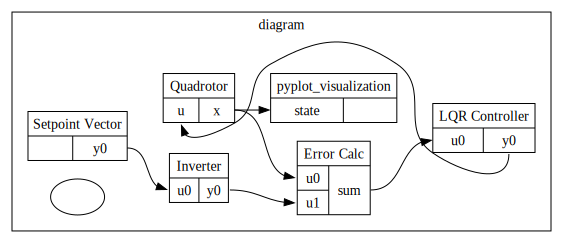

In [24]:
planar_quadrotor_example()